# Exercise 8: Transformer (Solution)

In this exercise, you will implement a Transformer, sort some lists and solve CartPole with Imitation Learning.

### Setup
Import useful libraries, set configs and seed.

In [2]:
import random
import math
import numpy as np
import argparse
import gymnasium as gym

import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import Dataset


def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(3407)

np.set_printoptions(precision=3, suppress=1)

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Create GPT Model
Create the GPT model from scratch. The overall structure is as follows:


<img src="img/gpt_model.png" alt="Drawing" style="width: 200px;" align="center"/>

Reference: https://openai.com/research/language-unsupervised

### Task 1: Masked Multi Self Attention

Masked Multi Self Attention (MMSA) is the most important layer in the GPT Model. You will implement this module based on the following model figure. Notably, MMSA is the layer after embeddings.

<img src="img/multi_head_attention.png" alt="Drawing" style="width: 500px;" align="center"/>

In [3]:

class CausalSelfAttention(nn.Module):
    """
    A vanilla multi-head masked self-attention layer with a projection at the end.
    """

    def __init__(self, config):
        """
        Initialization
        """
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.q_encode = nn.Linear(config.n_embd, config.n_embd)
        self.k_encode = nn.Linear(config.n_embd, config.n_embd)
        self.v_encode = nn.Linear(config.n_embd, config.n_embd)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd)
        # regularization
        self.attn_dropout = nn.Dropout(config.attn_pdrop)
        self.resid_dropout = nn.Dropout(config.resid_pdrop)
        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                     .view(1, 1, config.block_size, config.block_size))
        self.n_head = config.n_head
        self.n_embd = config.n_embd

    def forward(self, x):
        """
        Forward pass
        Args: 
            x: [B, T, C]
        Returns: 
            y: [B, T, C]
        """
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)
        
        # calculate query, key, values for all heads
        q = self.q_encode(x)
        k = self.k_encode(x)
        v = self.v_encode(x)
        
        # divide features into multiple heads and move head forward to be the batch dim
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs), C=nh*hs
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        
        # ========================================== # 
        # TODO: causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)   
        # Hint: use matrix multiplication to calculate attention `@`
        #           note that the `@` operator works also for tensors, matrices with more then 2 dimensions
        #           if we look at `A @ B`, it will work with the following shapes:
        #                   (..., i, j) x (..., j, i) -> (..., i).
        #       you also probably need to transpose either the k or q matrix `k.transpose(-2, -1)`
        #       you also should not forget the skaling ;) you can access the dim by `k.size(-1)`
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        # ========================================== # 
    
        mask_lower_trianguler = (self.bias[:,:,:T,:T] == 0)
        # ========================================== # 
        # TODO: mask irrelevant attentions (set logit equal to float('-inf') so that casual properties hold 
        #       and normalize attentions with softmax
        # Hint: use the mask_lower_triangular matrix, and masked_fill function in torch to set
        att = att.masked_fill(mask_lower_trianguler, float('-inf'))
        # ========================================== # 

        att = F.softmax(att, dim=-1)
    
        # attention dropout for generalization
        att = self.attn_dropout(att)
        y = att @ v 
        
        # regather all heads
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side
        
        # output projection and dropout
        y = self.resid_dropout(self.c_proj(y))
        return y
    

### Task 2: Repeated Block

In GPT, there are 12 layers of repeated blocks. This block is usually identified as the basic layer in most transofrmer models. You will now implement this block using multi-haed attetion module defined in last task.


In [4]:

# https://github.com/karpathy/minGPT/issues/33

class NewGELU(nn.Module):
    """
    Implementation of the GELU activation function currently in Google BERT repo (identical to OpenAI GPT).
    Reference: Gaussian Error Linear Units (GELU) paper: https://arxiv.org/abs/1606.08415
    """
    def forward(self, x):
        return 0.5 * x * (1.0 + torch.tanh(math.sqrt(2.0 / math.pi) * (x + 0.044715 * torch.pow(x, 3.0))))


class Block(nn.Module):
    """ an unassuming Transformer block """

    def __init__(self, config):
        """
        Initialization
        """
        super().__init__()
        self.ln_1 = nn.LayerNorm(config.n_embd)
        self.attn = CausalSelfAttention(config)
        self.ln_2 = nn.LayerNorm(config.n_embd)
        self.mlp = nn.ModuleDict(dict(
            c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd),
            c_proj  = nn.Linear(4 * config.n_embd, config.n_embd),
            act     = NewGELU(),
            dropout = nn.Dropout(config.resid_pdrop),
        ))
        m = self.mlp
        self.mlpf = lambda x: m.dropout(m.c_proj(m.act(m.c_fc(x)))) # MLP forward

    def forward(self, x):
        """
        Forward pass
        Args:
            x: [B, T, C]
        Returns:
            y: [B, T, C]
        """
        # ========================================== # 
        # TODO: calculate outputs of one layer
        #       Hint: Think about the skip connections.
        # gpt1 style
        x = self.ln_1(x + self.attn(x))
        y = self.ln_2(x + self.mlpf(x))
        # # gpt2 style
        # x = x + self.attn(self.ln_1(x))
        # y = x + self.mlpf(self.ln_2(x))
        # ========================================== # 
        return y



### Task 3: GPT Model
Now it's time to gather all previous defined modules and create the full GPT model. We provide a toy configurates of the gpt model. The primary parameters of a transformer model are n_layer, n_head and n_embd. 


In [5]:
def get_gpt_config():
    gpt_config = {}
    
    # model sizes
    # # gpt2
    # gpt_config['n_layer'] = 12
    # gpt_config['n_head'] = 12
    # gpt_config['n_embd'] = 768
    
    # gpt-nano
    gpt_config['n_layer'] = 3
    gpt_config['n_head'] = 3
    gpt_config['n_embd'] = 48
    
    # these options must be filled in externally
    gpt_config['vocab_size'] = None
    gpt_config['block_size'] = None
    gpt_config['act_num'] = None
    gpt_config['obs_dim'] = None
    gpt_config['episode_length'] = None
    
    # dropout hyperparameters
    gpt_config['embd_pdrop'] = 0.1
    gpt_config['resid_pdrop'] = 0.1
    gpt_config['attn_pdrop'] = 0.1

    # convert to argparse style
    gpt_config = argparse.Namespace(**gpt_config)

    return gpt_config


In [6]:
class GPT(nn.Module):
    """ GPT Language Model """

    def __init__(self, config):
        """
        Initialization
        """
        super().__init__()
        assert config.vocab_size is not None
        assert config.block_size is not None
        self.block_size = config.block_size
            
        self.token_embedding = nn.Embedding(config.vocab_size, config.n_embd)
        self.position_embedding = nn.Embedding(config.block_size, config.n_embd)
        self.dropout = nn.Dropout(config.embd_pdrop)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        self.layer_norm = nn.LayerNorm(config.n_embd)
        self.output_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)

        # init all weights, and apply a special scaled init to the residual projections, per GPT-2 paper
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.parameters())
        print("Size of parameters: %.2fM" % (n_params/1e6,))
        
        
    def _init_weights(self, module):
        """
        Initialize network's weights
        """
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)


    def forward(self, idx, targets=None):
        """
        Forward pass
        Args:
            idx: [B, T]
            targets: [B, T]
        Returns:
            logits: [B, T, V]
            loss: [1]
        """
        
        device = idx.device
        b, t = idx.size()
        assert t <= self.block_size, f"Cannot forward sequence of length {t}, block size is only {self.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # ========================================== # 
        # TODO: calculate token embedding and position embedding
        tok_emb = self.token_embedding(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.position_embedding(pos) # position embeddings of shape (1, t, n_embd)
        # ========================================== # 
    
        # dropout after embeddings
        x = self.dropout(tok_emb + pos_emb)
        
     
        for block in self.blocks:
            x = block(x)
        
        # calculate outputs
        x = self.layer_norm(x)
        logits = self.output_head(x)

        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            
        return logits, loss

    @torch.no_grad()
    def generate(self, idx, max_new_tokens, temperature=1.0, do_sample=False, top_k=None):
        """
        Take a conditioning sequence of indices idx (LongTensor of shape (b,t)) and complete
        the sequence max_new_tokens times, feeding the predictions back into the model each time.
        Most likely you'll want to make sure to be in model.eval() mode of operation for this.
        """
        for _ in range(max_new_tokens):
            # if the sequence context is growing too long we must crop it at block_size
            idx_cond = idx if idx.size(1) <= self.block_size else idx[:, -self.block_size:]
            # forward the model to get the logits for the index in the sequence
            logits, _ = self(idx_cond)
            # pluck the logits at the final step and scale by desired temperature
            logits = logits[:, -1, :] / temperature
            # optionally crop the logits to only the top k options
            if top_k is not None:
                v, _ = torch.topk(logits, top_k)
                logits[logits < v[:, [-1]]] = -float('Inf')
            # apply softmax to convert logits to (normalized) probabilities
            probs = F.softmax(logits, dim=-1)
            # either sample from the distribution or take the most likely element
            if do_sample:
                idx_next = torch.multinomial(probs, num_samples=1)
            else:
                _, idx_next = torch.topk(probs, k=1, dim=-1)
            # append sampled index to the running sequence and continue
            idx = torch.cat((idx, idx_next), dim=1)
        return idx
    
    
    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
                # random note: because named_modules and named_parameters are recursive
                # we will see the same tensors p many many times. but doing it this way
                # allows us to know which parent module any tensor p belongs to...
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

In [7]:
# create a GPT instance and tryout the model!
model_config = get_gpt_config()
model_config.vocab_size = 100 # train_dataset.get_vocab_size()
model_config.block_size = 10 # train_dataset.get_block_size()
model_config.n_embd = 48
print(model_config)
model = GPT(model_config)
print(model)

Namespace(n_layer=3, n_head=3, n_embd=48, vocab_size=100, block_size=10, act_num=None, obs_dim=None, episode_length=None, embd_pdrop=0.1, resid_pdrop=0.1, attn_pdrop=0.1)
Size of parameters: 0.09M
GPT(
  (token_embedding): Embedding(100, 48)
  (position_embedding): Embedding(10, 48)
  (dropout): Dropout(p=0.1, inplace=False)
  (blocks): ModuleList(
    (0): Block(
      (ln_1): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
      (attn): CausalSelfAttention(
        (q_encode): Linear(in_features=48, out_features=48, bias=True)
        (k_encode): Linear(in_features=48, out_features=48, bias=True)
        (v_encode): Linear(in_features=48, out_features=48, bias=True)
        (c_proj): Linear(in_features=48, out_features=48, bias=True)
        (attn_dropout): Dropout(p=0.1, inplace=False)
        (resid_dropout): Dropout(p=0.1, inplace=False)
      )
      (ln_2): LayerNorm((48,), eps=1e-05, elementwise_affine=True)
      (mlp): ModuleDict(
        (c_fc): Linear(in_features=48, o

### Create Trainer
Trainer is a class to manage the training process of the GPT model. It loads data and feeds them into the GPT model for iterations. This class is written already. 

In [8]:
from trainer import get_train_config, Trainer

## 2. Toy Example: Sort Array
Now you will try out the GPT model on a simple sortign example. 

The aim of the task is to sort the given array. 

E.g. for problem length 6, if the input is 0 0 2 1 0 1, the GPT model is expected to generate Output: 0 0 0 1 1 2.
    


### Build Dataset

In [9]:
import pickle

class SortDataset(Dataset):
    """ 
    Dataset for the Sort problem. E.g. for problem length 6:
    Input: 0 0 2 1 0 1 -> Output: 0 0 0 1 1 2
    Which will feed into the transformer concatenated as:
    input:  0 0 2 1 0 1 0 0 0 1 1
    output: -1 -1 -1 -1 -1 0 0 0 1 1 2
    where -1 is "ignore", as the transformer is reading the input sequence
    """

    def __init__(self, split, length=6, num_digits=3):
        assert split in {'train', 'test'}
        self.split = split
        self.length = length
        self.num_digits = num_digits
    
    def __len__(self):
        return 10000 # ...
    
    def get_vocab_size(self):
        return self.num_digits
    
    def get_block_size(self):
        # the length of the sequence that will feed into transformer, 
        # containing concatenated input and the output, but -1 because
        # the transformer starts making predictions at the last input element
        return self.length * 2 - 1

    def __getitem__(self, idx):
        
        # use rejection sampling to generate an input example from the desired split
        while True:
            # generate some random integers
            inp = torch.randint(self.num_digits, size=(self.length,), dtype=torch.long)
            # half of the time let's try to boost the number of examples that 
            # have a large number of repeats, as this is what the model seems to struggle
            # with later in training, and they are kind of rate
            if torch.rand(1).item() < 0.5:
                if inp.unique().nelement() > self.length // 2:
                    # too many unqiue digits, re-sample
                    continue
            # figure out if this generated example is train or test based on its hash
            h = hash(pickle.dumps(inp.tolist()))
            inp_split = 'test' if h % 4 == 0 else 'train' # designate 25% of examples as test
            if inp_split == self.split:
                break # ok
        
        # solve the task: i.e. sort
        sol = torch.sort(inp)[0]

        # concatenate the problem specification and the solution
        cat = torch.cat((inp, sol), dim=0)

        # the inputs to the transformer will be the offset sequence
        x = cat[:-1].clone()
        y = cat[1:].clone()
        # we only want to predict at output locations, mask out the loss at the input locations
        y[:self.length-1] = -1
        return x, y

play with the dataset with different paraemters and validate the inputs and outputs of the dataset

In [12]:
# print an example instance of the dataset
train_dataset = SortDataset('train', length=6, num_digits=3)
x, y = train_dataset[0]
print(f'Dataset Length: {len(train_dataset)}')
print(f'Input array: {x}\nOutput array: {y}')


Dataset Length: 10000
Input array: tensor([2, 0, 2, 1, 0, 0, 0, 0, 0, 1, 2])
Output array: tensor([-1, -1, -1, -1, -1,  0,  0,  0,  1,  2,  2])


### Train Model
Now you can feed the model and dataset in the Trainer and start to train! Observation the training loss is decreasing. 

In [13]:
# recreate a GPT instance
model_config = get_gpt_config()
model_config.vocab_size = train_dataset.get_vocab_size()
model_config.block_size = train_dataset.get_block_size()
model = GPT(model_config)
# setup training
train_config = get_train_config()
trainer = Trainer(train_config, model, train_dataset)
trainer.run()

Size of parameters: 0.09M
running on device cpu
iter_dt 0.00ms; iter 0: train loss 1.12949
iter_dt 31.65ms; iter 100: train loss 0.22771
iter_dt 30.69ms; iter 200: train loss 0.06426
iter_dt 28.45ms; iter 300: train loss 0.04241
iter_dt 30.82ms; iter 400: train loss 0.00832
iter_dt 28.83ms; iter 500: train loss 0.02306
iter_dt 27.81ms; iter 600: train loss 0.00630
iter_dt 31.60ms; iter 700: train loss 0.01582
iter_dt 28.72ms; iter 800: train loss 0.01907
iter_dt 29.07ms; iter 900: train loss 0.00947
iter_dt 31.33ms; iter 1000: train loss 0.02322
iter_dt 28.82ms; iter 1100: train loss 0.01350
iter_dt 29.11ms; iter 1200: train loss 0.02150
iter_dt 28.70ms; iter 1300: train loss 0.01703
iter_dt 29.16ms; iter 1400: train loss 0.02107
iter_dt 27.40ms; iter 1500: train loss 0.00116
iter_dt 29.66ms; iter 1600: train loss 0.00119
iter_dt 31.56ms; iter 1700: train loss 0.01725
iter_dt 30.24ms; iter 1800: train loss 0.00030
iter_dt 27.64ms; iter 1900: train loss 0.01426


### Test Model
It's necessary to validate the trained model on new sequences. We can create a new array and ask GPT to generate the sorted array now!

In [14]:
# let's run a random given sequence through the model as well
n = train_dataset.length # naugy direct access shrug
inp = torch.tensor([[0, 0, 2, 1, 0, 1]], dtype=torch.long).to(trainer.device)
assert inp[0].nelement() == n
with torch.no_grad():
    cat = model.generate(inp, n, do_sample=False)
sol = torch.sort(inp[0])[0]
sol_candidate = cat[:, n:]
print('input sequence   :', inp.tolist())
print('predicted sorted :', sol_candidate.tolist())
print('ground truth sort:', sol.tolist())
print('matches          :', bool((sol == sol_candidate).all()))

input sequence   : [[0, 0, 2, 1, 0, 1]]
predicted sorted : [[0, 0, 0, 1, 1, 2]]
ground truth sort: [0, 0, 0, 1, 1, 2]
matches          : True


## 3. Control Example: Imitation Learning on Cartpole 

Lets' apply GPT model on some control tasks. Cart-pole is a good starting point since we already train a DQN policy to play cart-pole as follows.

Rollout ends with 100 steps


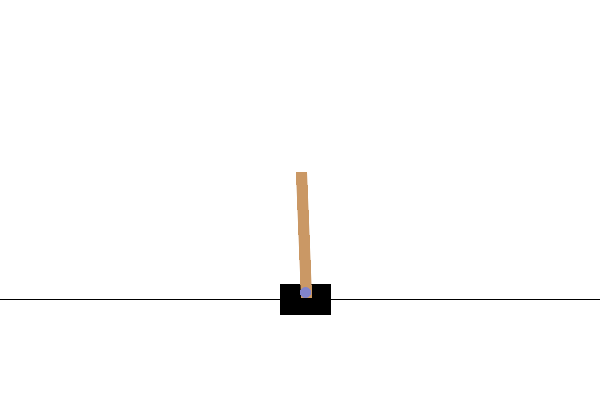

In [15]:
from dqn import DQNAgent
from utils import save_rgb_animation
from IPython.display import Image as IImage
from functools import partial

env = gym.make("CartPole-v1", render_mode="rgb_array", max_episode_steps=100)
env.observation_space, env.action_space

dqn = DQNAgent(env, gamma=0.99)
dqn.load('dqn_cartpole.pt')
expert_policy = partial(dqn.get_action,  epsilon=0.1)

def rendered_rollout(policy, env, max_steps=100):
    steps = 0
    state, _ = env.reset()
    imgs = [env.render()]

    while steps < max_steps:
        action = policy(state)
        state, _, terminated, truncated, _ = env.step(action)
        imgs.append(env.render())
        
        steps += 1
        if terminated or truncated:
            break
    print(f'Rollout ends with {steps} steps')
    return imgs

imgs = rendered_rollout(expert_policy, env)
save_rgb_animation(imgs, f"{env.spec.id}.gif", duration=40)
IImage(filename=f"{env.spec.id}.gif")


### Build Dataset

We now create a cart-pole dataset, so that it can behave as a policy function $a_t \sim \pi(s_t)$ and imitate DQN policy. In our setup, we can actaully use all previous trajectorie $h_t = (s_0, a_0, \cdots, s_t, a_t)$ as inputs. The practical model is $a_t=\text{GPT}(h_{t-1}, s_t)$.  

The cliff walking dataset should have the strucutes:

Input: $(s_0, a_0, \cdots, s_t, a_t)$

Output: $(a_0, a_1, \cdots, a_t)$

The main difference to SortDataset is that state now a 4-d continuous variable. The input should have dimensions [T, 5], and output dimensions [T]. 

In [20]:

from collections import namedtuple
Trajectory  = namedtuple("Trajectory", ("obses", "acts", "rewards", "next_obses"))


def rollout_env(env, episode_length, num_episodes, use_expert=False):
    rollouts = []
    
    for _ in range(num_episodes):
        obses, acts, rewards, next_obses = [], [], [], []
        next_obs, _ = env.reset()
        for _ in range(episode_length):
            obs = next_obs
            if use_expert:
                act = expert_policy(obs) # choose a random action
            else:
                act = env.action_space.sample()  # choose a random action
            next_obs, reward, terminated, truncated, _ = env.step(act) # step in the enviornment
            obses.append(obs)
            acts.append(act)
            rewards.append(reward)
            next_obses.append(next_obs)
    
        trajectory = Trajectory(np.array(obses), np.array(acts), np.array(rewards), np.array(next_obses))
        rollouts.append(trajectory)
    return rollouts


class GymDataset(Dataset):
    """ 
    Dataset 
    """
    def __init__(self, env_name="CartPole-v1", 
                 episode_length=20, 
                 num_episodes=1000, 
                 use_expert=False):
        
        # gym environment
        self.gym_env = gym.make(env_name)
        self.observation_space = self.gym_env.observation_space
        self.action_space = self.gym_env.action_space
     
        # dataset statistics
        self.episode_length = episode_length
        self.num_episodes = num_episodes
        
        # create datasets by rollout
        self.rollouts = rollout_env(self.gym_env, self.episode_length, self.num_episodes, use_expert)
        
    def __len__(self):
        return  self.num_episodes 
    
    def get_block_size(self):
        # s0, a0, s1, a1, ..., s_{T}
        return self.episode_length * 2

    def __getitem__(self, idx):
        # x: s0, a0, s1, a1...
        # y: a0, s1, a1, s2... (-1 means output mask)
        
        trajectory = self.rollouts[idx]
        
        # create inputs and outputs
        obses = torch.tensor(trajectory.obses, dtype=torch.long) # [T, obs_dim]
        acts = torch.tensor(trajectory.acts, dtype=torch.long) # [T]
        x = torch.cat([obses, acts.reshape(-1, 1)], dim=1) # [T, obs_dim+1]
        y = torch.tensor(trajectory.acts, dtype=torch.long) # [T]
        return x, y

In [21]:
# print an example instance of the dataset
train_dataset = GymDataset(env_name="CartPole-v1", use_expert=True, episode_length=40, num_episodes=1000)
            
x, y = train_dataset[0] 
print(f'Dataset Length: {len(train_dataset)}')
print(f'Input array: {x.shape}\nOutput array: {y.shape}')


Dataset Length: 1000
Input array: torch.Size([40, 5])
Output array: torch.Size([40])


### Rebuild Model

Since the observation is a 4d continous variable, it's necessary to use Linear layer instead of Embedding layer to encode observation information. Action can still use Embedding layer. Both action and observation share a same timestep embedding.

In [22]:

class GymGPT(nn.Module):
    """ GPT Model on gym tasks"""

    def __init__(self, config):
        """
        Initialization
        """
        super().__init__()
        assert config.obs_dim is not None
        assert config.act_num is not None
        assert config.episode_length is not None 
        
        self.block_size = config.block_size
        self.hidden_size = config.n_embd
        self.obs_dim = config.obs_dim
        
        # embedding layers
        self.embed_timestep = nn.Embedding(config.episode_length, self.hidden_size)
        self.embed_obs = nn.Linear(config.obs_dim , self.hidden_size)
        self.embed_act = nn.Embedding(config.act_num, self.hidden_size)
        
        # transformer layers
        self.dropout = nn.Dropout(config.embd_pdrop)
        self.blocks = nn.ModuleList([Block(config) for _ in range(config.n_layer)])
        # output layers
        self.layer_norm = nn.LayerNorm(config.n_embd)
        self.output_head = nn.Linear(config.n_embd, config.act_num, bias=False)

        # init all weights, and apply a special scaled init to the residual projections, per GPT-2 paper
        self.apply(self._init_weights)
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters (note we don't count the decoder parameters in lm_head)
        n_params = sum(p.numel() for p in self.parameters())
        print("Size of parameters: %.2fM" % (n_params/1e6,))
        
        
    def _init_weights(self, module):
        """
        Initialize network's weights
        """
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        elif isinstance(module, nn.LayerNorm):
            torch.nn.init.zeros_(module.bias)
            torch.nn.init.ones_(module.weight)


    def forward(self, x, targets=None):
        """
        Forward pass
        Args:
            x: [B, T, obs_dim_+1]
            targets: [B, T]
        Returns:
            logits: [B, T, V]
            loss: [1]
        """
        obses, acts = x.split(self.obs_dim, dim=2)
        obses = obses.squeeze(-1).to(torch.float) 
        acts = acts.squeeze(-1).to(torch.long)
        
        device = obses.device
        b, t, _ = obses.size()
      
        timesteps = torch.arange(0, t, dtype=torch.long, device=device).unsqueeze(0) # shape (1, t)

        # ========================================== # 
        # calculate token embedding and position embedding
        obs_embeddings = self.embed_obs(obses) # [b, t, n_embd]
        act_embeddings = self.embed_act(acts) # [b, t, n_embd]
        time_embeddings = self.embed_timestep(timesteps) # [b, t, n_embd]

        # time embeddings are treated similar to positional embeddings
        obs_embeddings = obs_embeddings + time_embeddings
        act_embeddings = act_embeddings + time_embeddings
        
        # this makes the sequence look like (s_1, a_1, s_2, a_2, ...)
        x = torch.stack(
            [obs_embeddings, act_embeddings], dim=1
        ).permute(0, 2, 1, 3).reshape(b, 2*t, self.hidden_size) # [b, 2*t, n_embd]
        # ========================================== # 
        
        # dropout after embeddings
        x = self.dropout(x)
        
        # go through all blocks
        for block in self.blocks:
            x = block(x)
   
        # calculate outputs
        x = self.layer_norm(x)
        logits = self.output_head(x) # # [b, 2*t, num_act]
        logits = logits[:, ::2, :] # only predict act on obs token
        
        # if we are given some desired targets also calculate the loss
        loss = None
        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=-1)
            
        return logits, loss

    
    def configure_optimizers(self, train_config):
        """
        This long function is unfortunately doing something very simple and is being very defensive:
        We are separating out all parameters of the model into two buckets: those that will experience
        weight decay for regularization and those that won't (biases, and layernorm/embedding weights).
        We are then returning the PyTorch optimizer object.
        """

        # separate out all parameters to those that will and won't experience regularizing weight decay
        decay = set()
        no_decay = set()
        whitelist_weight_modules = (torch.nn.Linear, )
        blacklist_weight_modules = (torch.nn.LayerNorm, torch.nn.Embedding)
        for mn, m in self.named_modules():
            for pn, p in m.named_parameters():
                fpn = '%s.%s' % (mn, pn) if mn else pn # full param name
                # random note: because named_modules and named_parameters are recursive
                # we will see the same tensors p many many times. but doing it this way
                # allows us to know which parent module any tensor p belongs to...
                if pn.endswith('bias'):
                    # all biases will not be decayed
                    no_decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, whitelist_weight_modules):
                    # weights of whitelist modules will be weight decayed
                    decay.add(fpn)
                elif pn.endswith('weight') and isinstance(m, blacklist_weight_modules):
                    # weights of blacklist modules will NOT be weight decayed
                    no_decay.add(fpn)

        # validate that we considered every parameter
        param_dict = {pn: p for pn, p in self.named_parameters()}
        inter_params = decay & no_decay
        union_params = decay | no_decay
        assert len(inter_params) == 0, "parameters %s made it into both decay/no_decay sets!" % (str(inter_params), )
        assert len(param_dict.keys() - union_params) == 0, "parameters %s were not separated into either decay/no_decay set!" \
                                                    % (str(param_dict.keys() - union_params), )

        # create the pytorch optimizer object
        optim_groups = [
            {"params": [param_dict[pn] for pn in sorted(list(decay))], "weight_decay": train_config.weight_decay},
            {"params": [param_dict[pn] for pn in sorted(list(no_decay))], "weight_decay": 0.0},
        ]
        optimizer = torch.optim.AdamW(optim_groups, lr=train_config.learning_rate, betas=train_config.betas)
        return optimizer

### Train Model

In [23]:
# recreate a GPT instance
model_config = get_gpt_config()
model_config.obs_dim = train_dataset.observation_space.shape[0]
model_config.act_num = train_dataset.action_space.n
model_config.episode_length = train_dataset.episode_length
model_config.block_size = train_dataset.get_block_size()
policy_model = GymGPT(model_config)

# setup training
train_config = get_train_config()
trainer = Trainer(train_config, policy_model, train_dataset)
trainer.run()


Size of parameters: 0.09M
running on device cpu
iter_dt 0.00ms; iter 0: train loss 0.69277
iter_dt 118.31ms; iter 100: train loss 0.64641
iter_dt 115.36ms; iter 200: train loss 0.60563
iter_dt 117.65ms; iter 300: train loss 0.59817
iter_dt 119.83ms; iter 400: train loss 0.56934
iter_dt 122.65ms; iter 500: train loss 0.59039
iter_dt 119.58ms; iter 600: train loss 0.58079
iter_dt 125.57ms; iter 700: train loss 0.56111
iter_dt 120.58ms; iter 800: train loss 0.54669
iter_dt 116.27ms; iter 900: train loss 0.50745
iter_dt 115.78ms; iter 1000: train loss 0.51583
iter_dt 117.04ms; iter 1100: train loss 0.54501
iter_dt 118.09ms; iter 1200: train loss 0.51117
iter_dt 152.50ms; iter 1300: train loss 0.51298
iter_dt 149.48ms; iter 1400: train loss 0.49687
iter_dt 119.16ms; iter 1500: train loss 0.48953
iter_dt 169.69ms; iter 1600: train loss 0.49039
iter_dt 117.37ms; iter 1700: train loss 0.47495
iter_dt 117.30ms; iter 1800: train loss 0.47930
iter_dt 139.82ms; iter 1900: train loss 0.47460


### Test Model

Use the GPT-based policy to predict the action and execute on environments. Compare with DQN policies.

/tmp/ipykernel_6655/130319746.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /root/pytorch/torch/csrc/utils/tensor_new.cpp:230.)
  inp_torch = torch.tensor([inp], dtype=torch.float).to(trainer.device)


Rollout ends with 99 steps


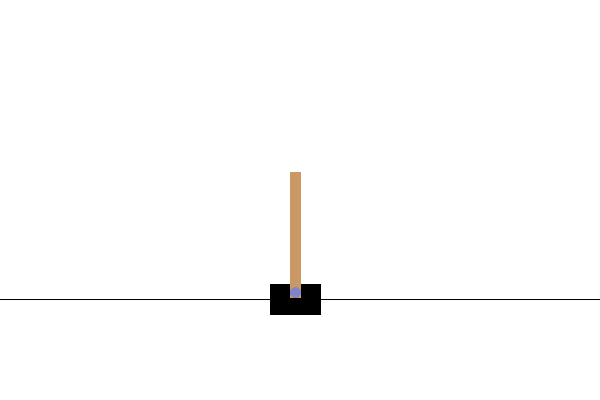

In [24]:

obs, _ = env.reset()
imgs = [env.render()]
inp = np.concatenate([obs, [0]]).reshape(1, -1) # [1,5]

for steps in range(100):
    
    # predict action with gpt
    inp_torch = torch.tensor([inp], dtype=torch.float).to(trainer.device)
    with torch.no_grad():
        logits, _ = policy_model(inp_torch)
        _, idx_next = torch.topk(logits, k=1, dim=-1)
        act = idx_next[0,-1, 0].cpu().numpy()

    # step environment
    next_obs, _,  terminated, truncated, _ = env.step(act)
    imgs.append(env.render())
    
    # create new input
    max_seq_len = train_dataset.episode_length
    inp[-1, -1] = act
    inp = np.concatenate([inp, np.concatenate([next_obs, [0]]).reshape(1, -1)])
    inp = inp[-max_seq_len:, :]
    
    if terminated or truncated:
        break

print(f'Rollout ends with {steps} steps')

save_rgb_animation(imgs, f"{env.spec.id}.gif", duration=40)
IImage(filename=f"{env.spec.id}.gif")
